# Урок 4. Алгоритм построения дерева решений

## Деревья решений

В этом уроке пойдет речь еще об одном популярном методе машинного обучения - _деревьях решений_. Это семейство алгоритмов значительно отличается от линейных моделей, но применяется также в задачах классификации и регрессии.

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, в обсуждаемой ранее задаче кредитного скоринга может быть следующий алгоритм принятия решения:

1. Старше ли клиент 18 лет? Если да, то продолжаем, иначе отказываем в кредите.

2. Превышает ли его заработок 50 тысяч рублей? Если да, то продолжаем, иначе отказываем в кредите.

3. Были ли у клиента просроченные кредиты ранее? Если да, отказываем в кредите, иначе выдаем.

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

<img src="images/L4_graphviz.png" width="800">

In [1]:
# визуализировать дерево можно с помощью библиотеки python-graphviz
# https://nbviewer.jupyter.org/github/xflr6/graphviz/blob/master/examples/graphviz-notebook.ipynb
!pip install graphviz
import graphviz
from graphviz import Digraph



/home/mariya/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/mariya/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 46 kB 999 kB/s eta 0:00:01


In [2]:

import logging
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

In [3]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='Клиент старше 18 лет?')
dot.node('B', label='Превышает ли его заработок 50 тысяч рублей?')
dot.node('C', label='Отказать')
dot.node('D', label='Были ли у клиента просроченные кредиты ранее?')
dot.node('E', label='Отказать')
dot.node('F', label='Отказать')
dot.node('G', label='Выдать')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

print(dot.source)  

digraph {
	node [shape=box]
	A [label="Клиент старше 18 лет?"]
	B [label="Превышает ли его заработок 50 тысяч рублей?"]
	C [label="Отказать"]
	D [label="Были ли у клиента просроченные кредиты ранее?"]
	E [label="Отказать"]
	F [label="Отказать"]
	G [label="Выдать"]
	A -> B [label="да"]
	A -> C [label="нет"]
	B -> D [label="да"]
	B -> E [label="нет"]
	D -> F [label="да"]
	D -> G [label="нет"]
}



[DEBUG@graphviz.backend.execute] run [PosixPath('dot'), '-Kdot', '-Tsvg']


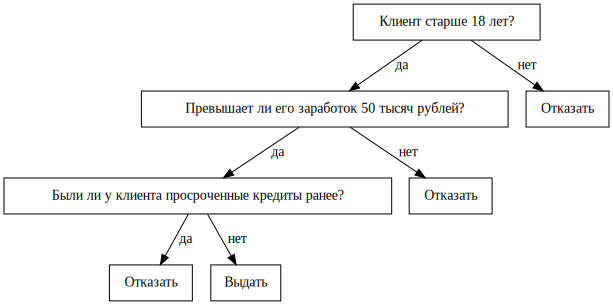

In [59]:
dot

In [5]:
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.disable)

В задачах машинного обучения чаще всего в вершинах прописываются максимально простые условия. Обычно это сравнение значения одного из признаков $x^{j}$ с некоторым заданным порогом $t$:

$$[x^{j} \leq t].$$

Если решается задача классификации, конечным прогнозом является класс или распределение вероятностей классов. В случае регрессии прогноз в листе является вещественным числом.

Большим плюсом деревьев является тот факт, что они легко интерпретируемы. 

## Построение деревьев решений

Деревья обладают и отрицательными качествами - в частности, они очень легко переобучаются. Легко построить дерево, в котором каждый лист будет соответствовать одному объекту обучающей выборки. Оно будет идеально подогнано под обучающую выборку, давать стопроцентный ответ на ней, но при этом не будет восстанавливать оригинальных закономерностей, и качество ответов на новых данных будет неудовлетворительным.

В машинном обучении деревья строятся последовательно от корня к листьям (так называемый "жадный" способ). Вначале выбирается корень и критерий, по которому выборка разбивается на две. Затем то же самое делается для каждого из потомков этого корня и так далее до достаточного уровня ветвления. Задача состоит в выборе способа **разбиения каждого из узлов**, то есть в выборе значения порога, с которым будет сравниваться значение одного из признаков в каждом узле.

Разбиение выбирается с точки зрения некоторого заранее заданного функционала качества $Q(X, j, t)$. Находятся наилучшие значения $j$ и $t$ для создания _предиката_ $[x^{j}<t]$. **Параметры $j$ и $t$ можно выбирать перебором:** признаков конечное число, а из всех возможных значений порога $t$ можно рассматривать только те, при которых получаются различные разбиения на две подвыборки, таким образом, различных значений параметра $t$ будет столько же, сколько различных значений признака $x^{j}$ в обучающей выборке.

В каждой вершине производится проверка, не выполнилось ли некоторое условие останова (критерии останова рассмотрим далее), и если оно выполнилось, разбиение прекращается, и вершина объвляется листом, и он будет содержать прогноз.

В задаче классификации это будет класс, к которому относится большая часть объектов из выборки в листе $X_{m}$

$$a_{m} = \text{argmax}_{y \in Y} \sum_{i \in X_{m}}[y_{i}=y]$$

или доля объектов определенного класса $k$, если требуется предсказать вероятности классов

$$a_{mk} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}[y_{i}=k].$$

В случае регрессии можно в качестве ответа давать средний по выборке в листе

$$a_{m} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}y_{i}.$$

После построения дерева может проводиться его _стрижка_ (pruning) - удаление некоторых вершин согласно некоторому подходу с целью понижения сложности модели и повышения обобщающей способности.

Лист: 

    0(y1)  0(y2) 0 0 1
1) y=0,     4 объекта

2) y=1, 1 Объект

y=0

1) y=0,     4 объекта

2) y=1, 1 Объект

4/5 1/5

(0,2 + 0,3 + 0,5)/3

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

### Критерий информативности

В случае **регрессии** разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

В задаче **классификации** есть несколько способов определить критерий информативности.

**1)** Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

**2)** _Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

**3)** Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Прирост информации есть утрата неопределенности (=уменьшение энтропии). Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$ 


In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[DEBUG@matplotlib.pyplot] Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [51]:
# Расчет критерия 'энтропии
def entr(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p > 0:
          impurity -= p * np.log2(p)
        
    return impurity, classes

In [52]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity, classes

In [53]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [54]:
x = X[2,:]
print(x)
print(y)
print(x >= 1000)
print(y[x >= 1000])
right_1 = (y[x >= 1000] == 0)
right_2 = (y[x >= 1000] == 1)
print('Нулей:', right_1.sum(), 'единиц:', right_2.sum())

[ 500.  700.  750.  600. 1450.  800. 1500. 2000.  450. 1000.]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
[False False False False  True False  True  True False  True]
[1. 1. 0. 1.]
Нулей: 1 единиц: 3


Как работает коэффициент Джини

In [55]:
print(y[x >= 1000])
i, c = gini(y[x >= 1000])
print(i, c)

print(y[x < 1000])
i, c = gini(y[x < 1000])
print(i, c)

[1. 1. 0. 1.]
0.375 {1.0: 3, 0.0: 1}
[0. 0. 1. 0. 0. 1.]
0.4444444444444445 {0.0: 4, 1.0: 2}


Как работает энтропия

In [56]:
print(y[x >= 1000])
i, c = entr(y[x >= 1000])
print(i, c)

print(y[x < 1000])
i, c = entr(y[x < 1000])
print(i, c)

[1. 1. 0. 1.]
0.8112781244591328 {1.0: 3, 0.0: 1}
[0. 0. 1. 0. 0. 1.]
0.9182958340544896 {0.0: 4, 1.0: 2}


In [57]:
# Расчет прироста качества (при разбиении вершины дерева)

def quality_0(left_labels, right_labels):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    gini_left, _ = gini(left_labels)
    gini_right, _ = gini(right_labels)
    
    return p * gini_left + (1 - p) * gini_right, p * gini_left , (1 - p) * gini_right

Порог: 500.0, gini = 0.4444444444444444 (0.0,0.4444444444444444)
Порог: 700.0, gini = 0.47619047619047616 (0.13333333333333333,0.34285714285714286)
Порог: 750.0, gini = 0.4166666666666667 (0.15000000000000002,0.26666666666666666)
Порог: 600.0, gini = 0.5 (0.1,0.4)
Порог: 1450.0, gini = 0.4761904761904763 (0.3428571428571429,0.13333333333333336)
Порог: 800.0, gini = 0.48 (0.24,0.24)
Порог: 1500.0, gini = 0.5 (0.4,0.09999999999999998)
Порог: 2000.0, gini = 0.4444444444444444 (0.4444444444444444,0.0)
Порог: 450.0, gini = 0.5 (0.0,0.5)
Порог: 1000.0, gini = 0.4166666666666667 (0.26666666666666666,0.15000000000000002)


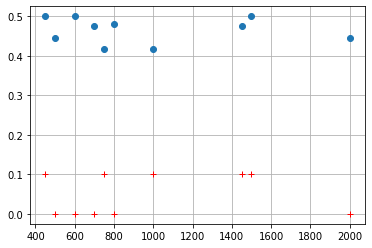

In [58]:
Gini_tr = []
for t in x:
    g, lg,rg = quality_0(y[x < t], y[x >= t])
    Gini_tr.append([t,g])
    print('Порог: {}, gini = {} ({},{})'.format(t,g,lg,rg ))

Gini_tr = np.array(Gini_tr)


plt.plot(Gini_tr[:,0],Gini_tr[:,1], 'o')
plt.plot(x,y/10,'+r', )
plt.grid(True)
plt.show()    

### Критерии останова

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

### Обрезка деревьев

В случае применения метода стрижки (обрезки, прунинга) деревьев использовать критерии останова необязательно, и можно строить переобученные деревья, затем снижая их сложность, удаляя листья по некоторому критерию (например, пока улучшается качество на отложенной выборке). Считается, что стрижка работает лучше, чем критерии останова.

Одним из методов стрижки является _cost-complexity pruning_. Допустим, мы построили дерево, обозначенное как $T_{0}$. В каждом из листьев находятся объекты одного класса, и значение функционала ошибки $R(T)$ при этом будет минимально на $T_{0}$. Для борьбы с переобучением к нему добавляют "штраф" за размер дерева (аналогично регуляризации, рассмотренной нами в предыдущих уроках) и получают новый функционал $R_{\alpha}(T)$:

$$R_{\alpha}(T) = R(T) + \alpha|T|,$$

где $|T|$ - число листьев в дереве, $\alpha$ - некоторый параметр регуляризации. Таким образом если при построении дерева на каком-то этапе построения алгоритма ошибка будет неизменна, а глубина дерева увеличиваться, итоговый функционал, состоящий из их суммы, будет расти.

Однако стрижка деревьев обладает существенными минусами. В частности, она является очень трудоемкой процедурой. Например, она может требовать вычисления функционала качества на валидационной выборке на каждом шаге. К тому же, на данный момент одиночные деревья на практике почти не используются, а используются композиции деревьев, и в этом случае стрижка как метод борьбы с переобучением становится еще более сложным подходом. Обычно в такой ситуации достаточно использовать простые критерии останова.

## CART

CART (Classification and regression trees) - первый из алгоритмов, состоящий в обычном последовательном построении дерева решений и придуманный в 1983 году. На первой итерации строятся все возможные разбиения исходного пространства на два и выбирается такое, при котором максимально выделен один из классов в одно подпространство. На следующих итерациях выбирается худший лист (с наибольшим разнообразием классов), и на нем проводится та же операция. Так продложается до достижения одного из критериев останова. 

Полученное дерево будет подогнано под обучающую выборку (переобучено), так что затем требуется его кросс-валидация или обрезка методом cost-complexity pruning. 

В качестве функции оценки качества разбиения используется критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

в sklearn реализована улучшенная версия именно алгоритма CART.

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

[DEBUG@matplotlib.pyplot] Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [18]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

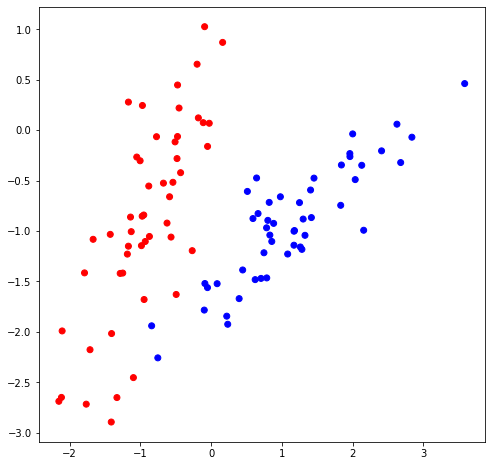

In [19]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [20]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [21]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$: $$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$
$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

In [22]:
# p = classes[label] / len(labels)

Критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [23]:
# impurity -= p ** 2

In [24]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

Функционал качества

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

In [25]:
# current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

$$\frac{|X_{l}|}{|X_{m}|}$$

In [26]:
# float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

In [27]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [28]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [29]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [30]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [31]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [32]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [33]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [34]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)
print(my_tree)
display(my_tree.index, my_tree.t, my_tree.true_branch , my_tree.false_branch)

0

0.16261402870113306

In [35]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [36]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[1, 1, 0, 0, 1]

In [37]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

Accuracy = расчет *доли правильных ответов*:

$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$

In [38]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [39]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [40]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

Text(0.5, 1.0, 'Test accuracy=100.00')

[DEBUG@matplotlib.font_manager] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono',

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Bold.ttf', name='Yrsa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Oblique.ttf', name='Purisa', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-Bold.ttf', name='Sawasdee', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-punjabi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truet

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-BoldOblique.ttf', name='Tlwg Typist', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/mry_KacstQurn.ttf', name='mry_KacstQurn', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lao/Phetsarath_OT.ttf', name='Phetsarath OT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Uroob-Regular.ttf', name='Uroob', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Bold.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: sc

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-LightItalic.otf', name='URW Bookman', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDigital.ttf', name='KacstDigital', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Dyuthi-Regular.ttf', name='Dyuthi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/font

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSansOblique.ttf', name='FreeSans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Gayathri-Thin.otf', name='Gayathri', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstTitleL.ttf', name='KacstTitleL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/S

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-Bold.ttf', name='Liberation Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Loma-Bold.ttf', name='Loma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman.ttf', name='Laksaman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truet

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Bold.ttf', name='Purisa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf', name='URW Gothic', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf', name='Ubuntu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/sh

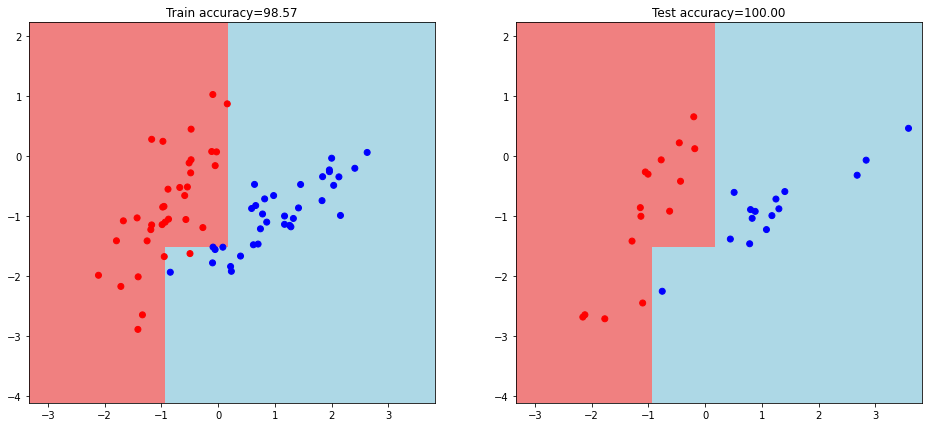

In [41]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

## Работа деревьев в случае пропущенных значений

Иногда в реальных задачах бывает так, что не для всех объектов известно значение того или иного признака. Одним из преимуществ деревьев решений является возможность обрабатывать такие случаи.

Допустим, требуется вычислить функционал качества для разбиения $[x_{j}<t]$, но в выборке $X_{m}$ для некоторого подмножества объектов $V_{j}$ неизвестно значение $j$-го признака. В этом случае функционал качества рассчитывается без учета этих объектов (обозначим выборку без их учета как $X_{m}\text{\ }V_{j}$), с поправкой на потерю информации:

$$Q_{X_{m}, j, t} = \frac{|X_{m}\text{\ } V_{j}|}{|X_{m}|}Q(X_{m}\text{\ }V_{j}, j,t).$$

Если такое разбиение окажется лучшим, объекты из $V_{j}$ помещаются в оба образованных поддерева.

На этапе применения дерева выполняется похожая операция. Если объект попал в вершину, в которой нельзя вычислить критерий разбиения из-за отсутствия значения необходимого признака, прогнозы для него вычисляются в обоих поддеревьях, а затем усредняются с весами, пропорциональными числу объектов в них.

$$\frac{|X_{l}|}{|X_{m}|}a_{l}(x) + \frac{|X_{r}|}{|X_{m}|}a_{r}(x),$$

где $a$ - прогноз вероятности отнесения объекта $x$ к одному из классов.

Кроме этого подхода существует метод построения _суррогатных предикатов_ в каждой вершине. Проще говоря, это запасной предикат, который использует другой признак, но при этом дает максимально близкое к исходному разбиение.

## Работа деревьев с категориальными признаками

Кроме вещественных и бинарных признаков в задаче могут иметь место категориальные признаки (делящиеся на конечное число категорий, например, цвета автомобилей). Самый простой способ учета категориальных признаков в алгоритме деревьев состоит в разбитии вершины на столько поддеревьев, сколько имеется возможных значений признака. В этом случае дерево называется _n-арным_. Условие разбиения будет простым (отнесение признака к той или иной категории), однако здесь появляется риск получения конечного дерева с очень большим числом листьев. В случае такого дерева критерий ошибки $Q$ будет состоять из $n$ слагаемых (или из $(n+1)$) в случае максимизируемого критерия, который мы использовали.

Есть и другой подход, заключающийся в формировании бинарных деревьев путем разделения множества значений признака $C = \{c_{1}, ...,c_{n}\}$ на два непересекающихся подмножества $C_{1}$ и $C_{2}$. После такого разделения условием разбиения в узле будет проверка принадлежности признака одному из подмножеств $[x \in C_{1}]$.

Задача остается в выборе оптимального варианта разбиения исходного множества на два подмножества, так как обычный перебор всех вариантов может быть крайне затруднительным из-за большого количества вариантов разбиения. В случаях с бинарной классификацией и регрессией используют следующий метод: все возможные значения категориального признака сортируются по определенному принципу, затем заменяются на натуральные числа.

В случае бинарной классификации признаки упорядочиваются на основе того, какая доля объектов с такими признаками относится к классу +1. Если обозначить множество объектов в узле $m$, у которых $j$-й признак имеет значение $с$, через $X_{m}(c)$, а через $N_{m}(c)$ количество таких объектов, получим:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}[y_{i}=+1]\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}[y_{i}=+1],$$

и после замены категории $c_{i}$ на натуральное число ищется разбиение как для вещественного признака.

В случае задачи регрессии сортировка происходит схожим образом, но вместо доли объектов положительного класса среди объектов с таким значением признака вычисляется средний ответ по объектам с соответствующим значением категориального признака:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}y_{i}\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}y_{i}.$$

Решающее дерево: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(train_data, train_labels)


DecisionTreeClassifier(max_depth=5, random_state=0)

In [44]:
# Точность на обучающей выборке
train_accuracy_s = accuracy_metric(train_labels,clf.predict(train_data))
train_accuracy_s,train_accuracy

(100.0, 98.57142857142858)

In [45]:
# Точность на тестовой выборке
test_accuracy_s = accuracy_metric(test_labels,clf.predict(test_data))
test_accuracy_s,test_accuracy

(100.0, 100.0)

Text(0.5, 1.0, 'Test accuracy=100.00')

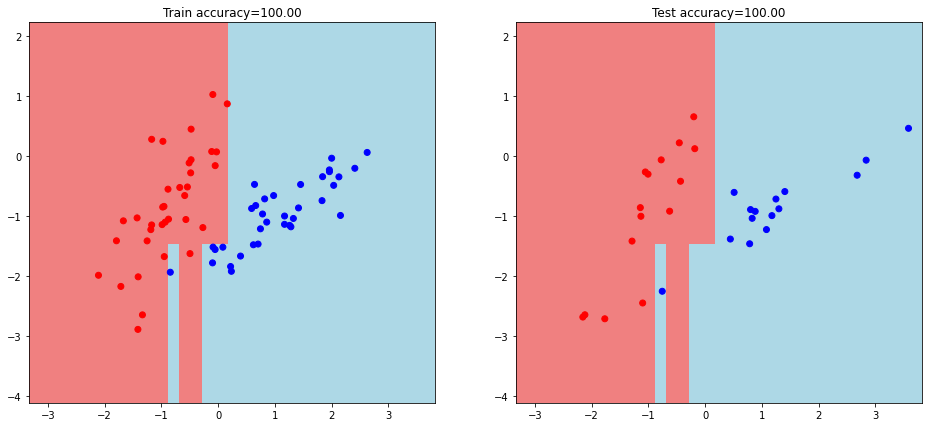

In [46]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(clf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_s:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_s:.2f}')

In [47]:
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.disable)

[Text(0.6666666666666666, 0.9166666666666666, 'X[0] <= 0.192\ngini = 0.5\nsamples = 70\nvalue = [35, 35]'),
 Text(0.5, 0.75, 'X[1] <= -1.469\ngini = 0.219\nsamples = 40\nvalue = [35, 5]'),
 Text(0.3333333333333333, 0.5833333333333334, 'X[0] <= -0.895\ngini = 0.486\nsamples = 12\nvalue = [7, 5]'),
 Text(0.16666666666666666, 0.4166666666666667, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.5, 0.4166666666666667, 'X[0] <= -0.296\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.3333333333333333, 0.25, 'X[0] <= -0.668\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.16666666666666666, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.5, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6666666666666666, 0.25, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.6666666666666666, 0.5833333333333334, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]'),
 Text(0.8333333333333334, 0.75, 'gini = 0.0\nsamples = 30\nvalue = [0, 30]')]

[DEBUG@matplotlib.font_manager] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.863636363636364.
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] fi

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/home/mariya/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono',

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Bold.ttf', name='Yrsa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Oblique.ttf', name='Purisa', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-Bold.ttf', name='Sawasdee', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-punjabi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truet

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-BoldOblique.ttf', name='Tlwg Typist', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/mry_KacstQurn.ttf', name='mry_KacstQurn', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lao/Phetsarath_OT.ttf', name='Phetsarath OT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Uroob-Regular.ttf', name='Uroob', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Bold.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: sc

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-LightItalic.otf', name='URW Bookman', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDigital.ttf', name='KacstDigital', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Dyuthi-Regular.ttf', name='Dyuthi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/font

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSansOblique.ttf', name='FreeSans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Gayathri-Thin.otf', name='Gayathri', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstTitleL.ttf', name='KacstTitleL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/S

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-Bold.ttf', name='Liberation Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Loma-Bold.ttf', name='Loma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman.ttf', name='Laksaman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truet

[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Bold.ttf', name='Purisa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf', name='URW Gothic', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf', name='Ubuntu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG@matplotlib.font_manager] findfont: score(FontEntry(fname='/usr/sh

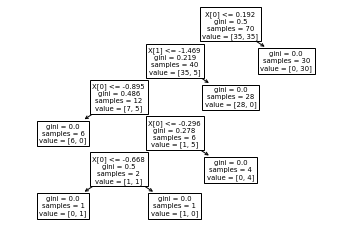

In [48]:
from sklearn import tree

tree.plot_tree(clf) 

[DEBUG@graphviz.backend.execute] run [PosixPath('dot'), '-Kdot', '-Tsvg']


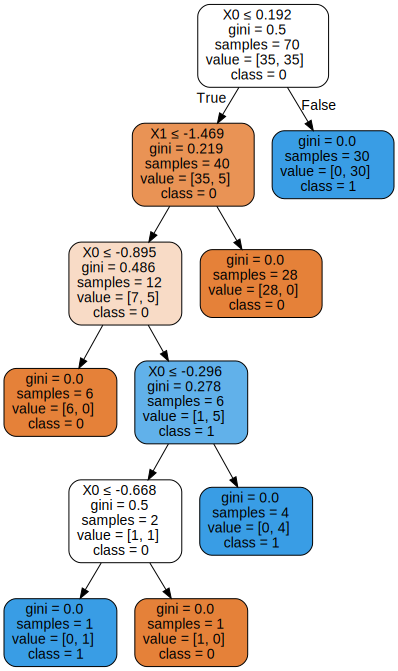

In [49]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=['X0','X1'],class_names=['0','1'], filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Дополнительные материалы

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Cost-Complexity Pruning](http://mlwiki.org/index.php/Cost-Complexity_Pruning)
4. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
5. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
6. [Пример работы дерева решений в задаче регрессии](https://habr.com/ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii)

## Summary

* Решающее дерево - последовательное построение узлов, разбивающих множество входящих объектов согласно принципу минимизации “нечистоты” (impurity) узла
* Предикаты для разбиения в узле выбираются из всего множества признаков
* Деревья могут легко переобучиться под выборку, если не ограничивать их глубину
* Деревья очень чувствительны к небольшим изменениям в выборке (шумам)